### 250424 Docker로 코드 실행
```
docker pull tensorflow/tensorflow:2.10.0-gpu

docker run --gpus all -it -v C:\Workspace\tf_docker:/workspace --name tf-workspace tensorflow/tensorflow:2.10.0-gpu bash

Dockerfile:
FROM tensorflow/tensorflow:2.10.0-gpu
WORKDIR /workspace
COPY requirements.txt .
RUN pip install --upgrade pip
RUN pip install --no-cache-dir -r requirements.txt

requirements.txt:
numpy
matplotlib
requests
scipy
opencv-python
pillow
tensorflow-datasets
scikit-image
pixellib
pydot
imageio

In [1]:
%pip install scikit-learn
%pip install keras_tuner

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow import keras
import imageio
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import glob
import time
import PIL
from IPython import display
from sklearn.model_selection import train_test_split
import keras_tuner as kt

2025-04-25 03:08:16.795409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-25 03:08:17.337283: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
%matplotlib inline

#### 매직 명령어에 주석을 붙이면 실행이 안 됨
- %matplotlib inline # 시각화 결과를 ipynb 내에서 표시 <- 이런 식으로 하면 안 됨

In [4]:
print(tf.__version__)
print(imageio.__version__)

2.10.0
2.35.1


### 데이터셋: CIFAR 10
- 라벨링이 잘못된 특정 인덱스에 접근해서 수정해야 함
```
0	airplane
1	automobile
2	bird
3	cat
4	deer
5	dog
6	frog
7	horse
8	ship
9	truck
```

In [5]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

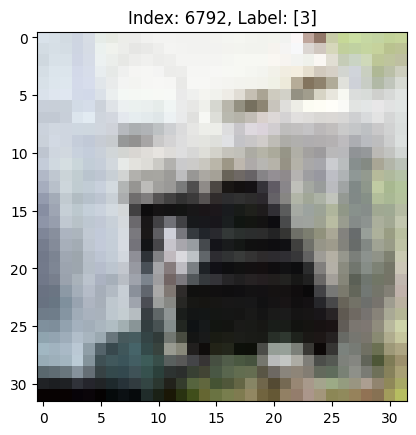

In [6]:
target_id = 6792

target_index = target_id

# 테스트 데이터셋에서 해당 인덱스의 이미지 가져오기
if 0 <= target_index < len(x_test):
    target_image = x_test[target_index]
    target_label = y_test[target_index]

    # 이미지 시각화
    plt.imshow(target_image)
    plt.title(f"Index: {target_index}, Label: {target_label}")
    plt.show()
else:
    print(f"ID {target_id}는 테스트 데이터셋 범위를 벗어납니다.")

### 이미지 확인 및 라벨 수정
- 데이터셋의 잘못된 라벨을 확인하고 시각화 및 수정하기
- https://labelerrors.com/에 명시되어있는 ID값을 참고하기
- 훈련 데이터셋의 인덱스를 확인해봤지만 ID값과 달랐음
- 테스트 데이터셋의 인덱스가 ID와 일치하였음

In [ ]:
def view_and_correct_label(x_data, y_data, index, new_label=None):
    """
    이미지를 보여주고 레이블을 선택적으로 수정하는 함수
    
    Parameters:
    -----------
    x_data : numpy.ndarray
        이미지 데이터 배열 >> train 또는 test
    y_data : numpy.ndarray
        레이블 데이터 배열 >> train 또는 test
    index : int
        확인/수정할 이미지의 인덱스
    new_label : int, optional
        새로 지정할 레이블, None인 경우 수정하지 않음
    
    Returns:
    --------
    original_label : int
        원래 레이블 값
    """
    
    # 원본 이미지와 레이블 표시
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(x_data[index])
    original_label = y_data[index][0]
    plt.title(f"Original image (Label: {original_label})")
    
    # 레이블 수정 (지정된 경우)
    if new_label is not None:
        y_data[index][0] = new_label
        
        # 수정된 레이블로 이미지 다시 표시
        plt.subplot(1, 2, 2)
        plt.imshow(x_data[index])
        plt.title(f"Corrected image (Original: {original_label}, New: {new_label})")
    
    plt.tight_layout()
    plt.show()
    
    return original_label

#### 이미지 확인 및 수정
- 몇몇 이미지는 라벨링이 제대로 되어있는 것 처럼 보여서 수정하지 않음

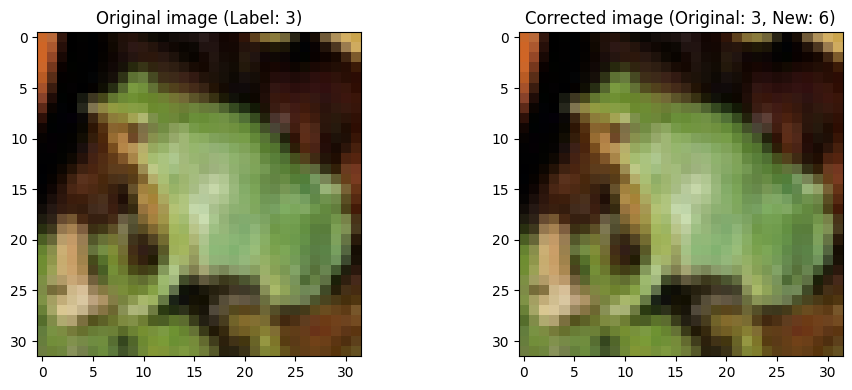

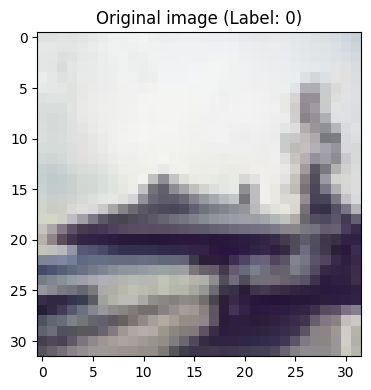

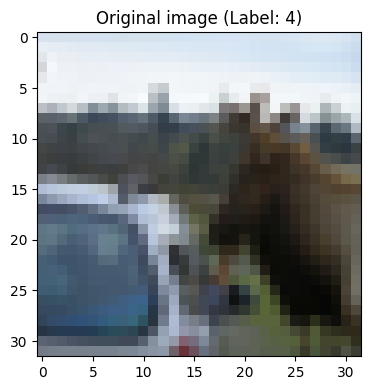

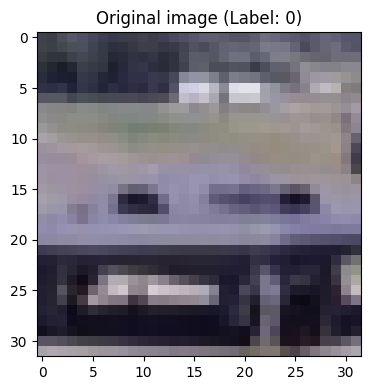

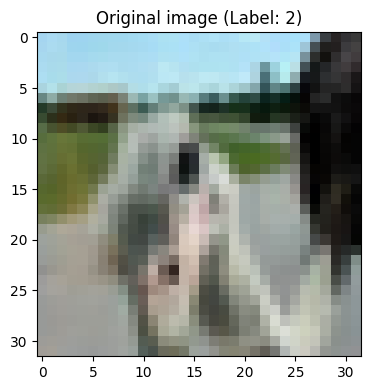

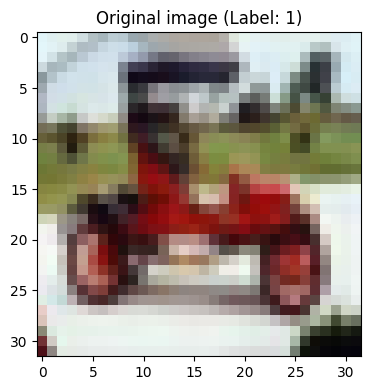

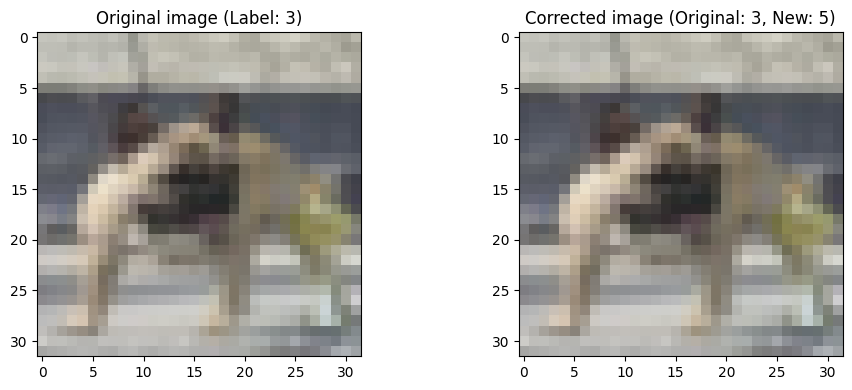

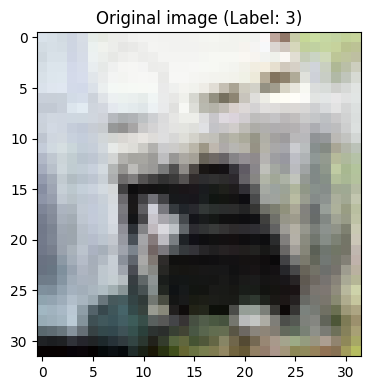

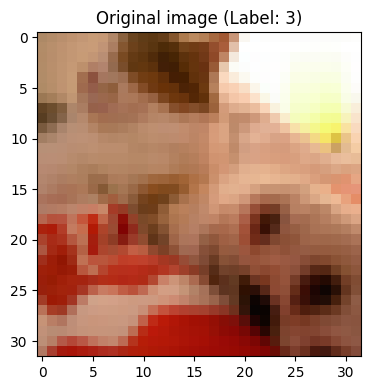

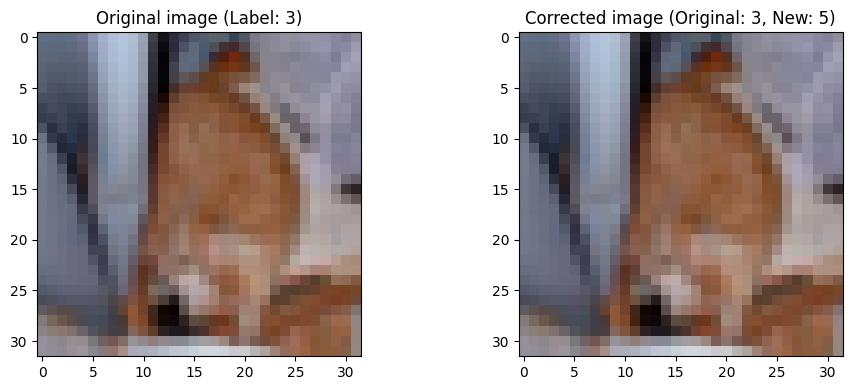

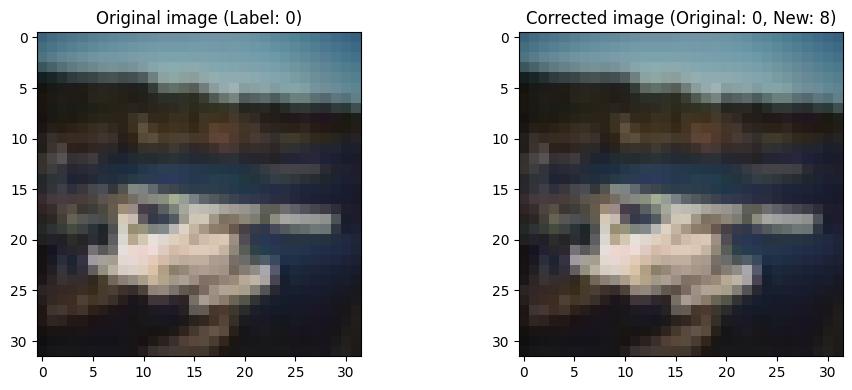

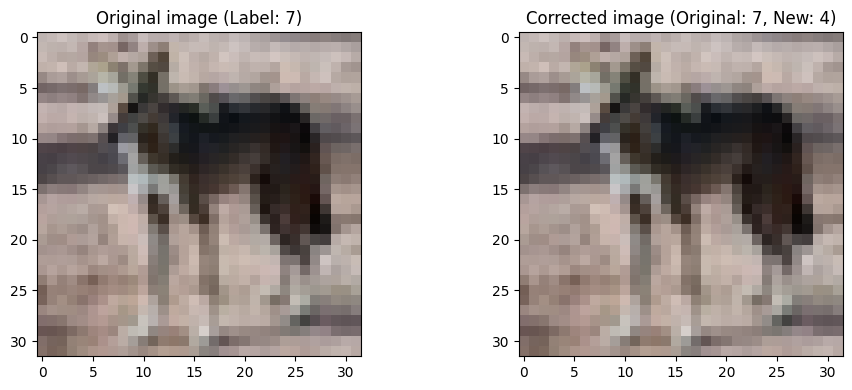

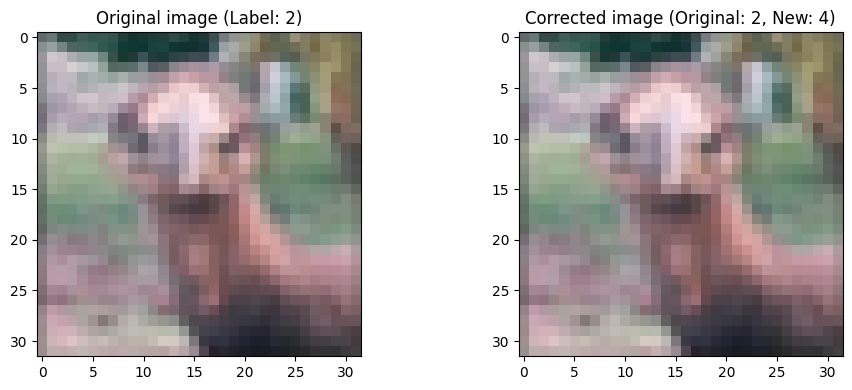

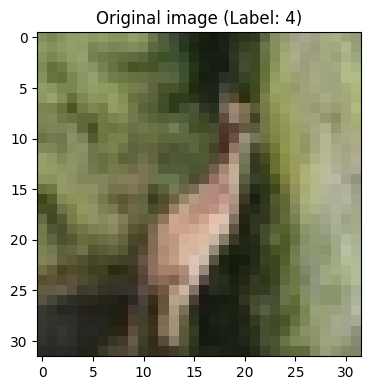

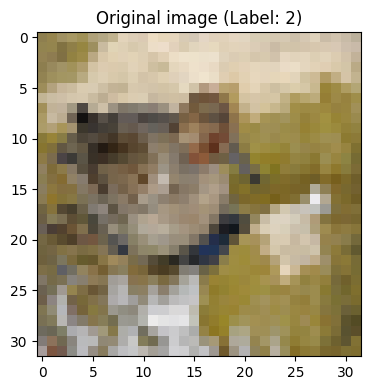

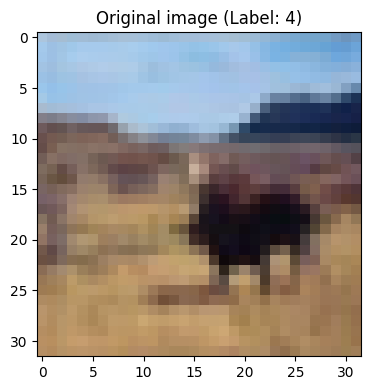

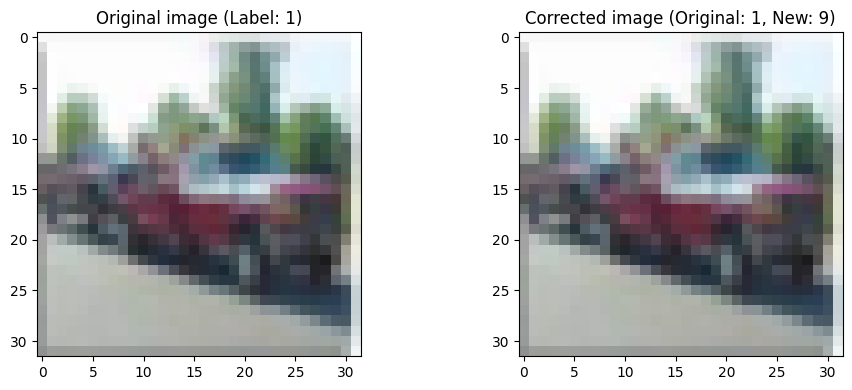

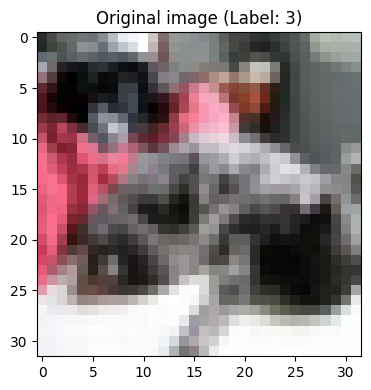

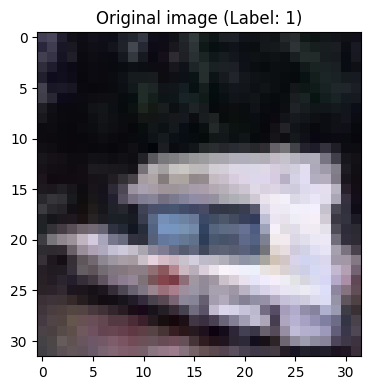

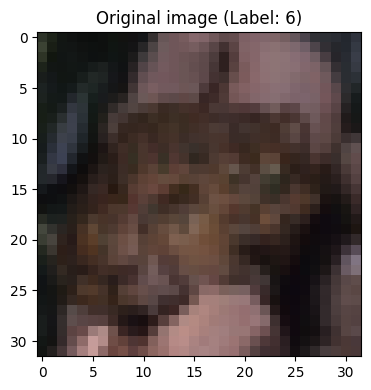

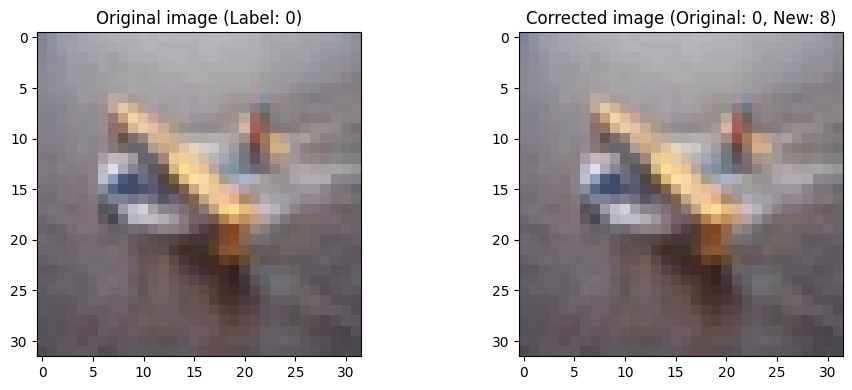

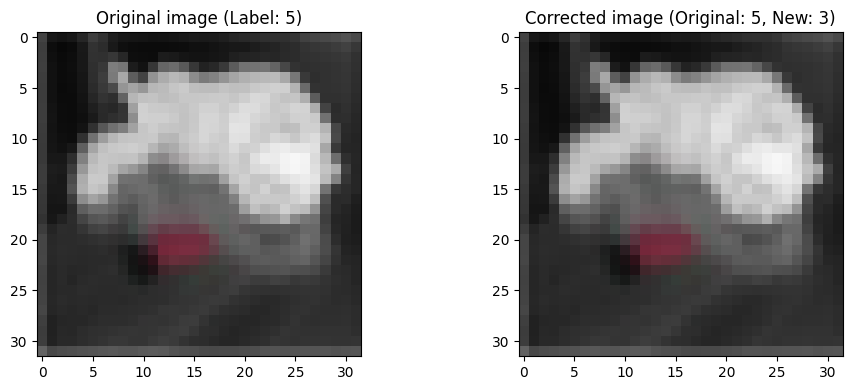

5

In [ ]:
view_and_correct_label(x_test, y_test, 2405, new_label=6)
view_and_correct_label(x_test, y_test, 6877) # 그냥 비행기 맞는 것 같음
view_and_correct_label(x_test, y_test, 8058) # 그냥 사슴 맞는 것 같음
view_and_correct_label(x_test, y_test, 2532)
view_and_correct_label(x_test, y_test, 7657) # 누가 봐도 타조임
view_and_correct_label(x_test, y_test, 1969) # 차 맞음
view_and_correct_label(x_test, y_test, 2804, new_label=5)
view_and_correct_label(x_test, y_test, 6792) # 뭔지 모르겠는데 고양이보단 트럭에 가까운듯
view_and_correct_label(x_test, y_test, 1227)
view_and_correct_label(x_test, y_test, 5191, new_label=5)
view_and_correct_label(x_test, y_test, 1718, new_label=8)
view_and_correct_label(x_test, y_test, 5690, new_label=4)
view_and_correct_label(x_test, y_test, 2592, new_label=4)
view_and_correct_label(x_test, y_test, 4794) # 너무 사슴임
view_and_correct_label(x_test, y_test, 5960)
view_and_correct_label(x_test, y_test, 165) # 새는 확실히 아님
view_and_correct_label(x_test, y_test, 9227, new_label=9)
view_and_correct_label(x_test, y_test, 5632) # 고양이 맞음
view_and_correct_label(x_test, y_test, 9352) # 캠핑카는 트럭일까 차량일까? 차량이 맞는 것 같음
view_and_correct_label(x_test, y_test, 7846) # 그냥 개구리가 맞음
view_and_correct_label(x_test, y_test, 6966, new_label=8)
view_and_correct_label(x_test, y_test, 5468, new_label=3)

In [9]:
# 분기 및 전처리

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


#### Keras Tuner
- 모델 구조는 고정하고 하이퍼 파라미터 튜닝하기
- 최적화된 하이퍼 파라미터로 모델 학습 진행하기기

In [10]:
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, x, y, validation_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(x, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)


        x_val, y_val = validation_data
        eval_scores = model.evaluate(x_val, y_val)
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = X_train.shape[1:], name = 'inputs'))
    for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
              model.add(tf.keras.layers.Conv2D(hp.Int(
                  'units_{i}'.format(i=i), min_value=32, max_value=128, step=5), (3,3),activation='relu'))
    model.add(tf.keras.layers.Flatten())
    for i in range(hp.Int('n_connections', 1, 3)):
        model.add(tf.keras.layers.Dense(hp.Choice(f'n_nodes',
                                  values=[32,64,128, 256]), activation = 'relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax', name = 'outputs'))
    model.compile(optimizer = 'adam',loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [11]:
# 모델 구조는 고정하고, 하이퍼 파라미터만 튜닝
# 손실 함수 확인

def build_model(hp):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(32, 32, 3)),
        layers.AveragePooling2D((2, 2)),
        layers.BatchNormalization(),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
        layers.AveragePooling2D((2, 2)),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(hp.Float('dropout_rate', 0.3, 0.7)),  # 튜닝
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')  # 튜닝
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

- categorical_crossentropy는 레이블이 원 핫 인코딩 되어있어야 함
- sparse_categorical_crossentropy는 레이블이 정수 인덱스 형태임
- (커널 크래시 생겨서 램 할당을 16GB로 변경함)

In [12]:
my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='my_keras_tuner')

my_keras_tuner.search(
    x_train, y_train, validation_data=(x_val, y_val), epochs=3)

Trial 10 Complete [00h 00m 20s]
accuracy: 0.6840999722480774

Best accuracy So Far: 0.6840999722480774
Total elapsed time: 00h 05m 30s


- Keras Tuner로 찾은 상위 10개 결과 중 가장 좋은 결과를 선택
- -> (num_trials)=10[0]
- model에 선택한 구조를 구축하고, 해당 모델에서 fit 진행

In [13]:
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 average_pooling2d_22 (Avera  (None, 15, 15, 32)       0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_22 (Bat  (None, 15, 15, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 average_pooling2d_23 (Avera  (None, 6, 6, 64)         0         
 gePooling2D)                                                    
                                                     

In [14]:
model.fit(x_train, y_train, batch_size=32, epochs = 5)

Epoch 1/5
1250/1250 [==============================] - 7s 5ms/step - loss: 1.5548 - accuracy: 0.4855
Epoch 2/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0372 - accuracy: 0.6389
Epoch 3/5
1250/1250 [==============================] - 6s 4ms/step - loss: 0.8608 - accuracy: 0.6978
Epoch 4/5
1250/1250 [==============================] - 7s 5ms/step - loss: 0.7386 - accuracy: 0.7411
Epoch 5/5
1250/1250 [==============================] - 6s 5ms/step - loss: 0.6360 - accuracy: 0.7752


In [15]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.9968 - accuracy: 0.6689


[0.996768057346344, 0.6689000129699707]

In [16]:
save_path = './best_model/1'
fname = os.path.join(save_path, 'model')
model.save(fname)

INFO:tensorflow:Assets written to: ./best_model/1/model/assets


INFO:tensorflow:Assets written to: ./best_model/1/model/assets


- 마운트한 윈도우 디렉토리에 저장되었음

In [18]:
print("현재 작업 디렉토리:", os.getcwd())
print("저장 경로 확인:", os.path.abspath('./best_model/1/model/assets'))

현재 작업 디렉토리: /workspace/250424
저장 경로 확인: /workspace/250424/best_model/1/model/assets


#### TFLite로 경랑화

- 모델을 저장했으므로 아래 코드만 다시 실행

In [2]:
import os
import tensorflow as tf

save_path = './best_model/1'
load_path = os.path.join(save_path, 'model')
best_model = tf.keras.models.load_model(load_path)

2025-04-25 04:17:52.793820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-25 04:17:52.812985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-25 04:17:52.813198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-25 04:17:52.814122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [ ]:
# 잘 불러왔는지 확인
best_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 average_pooling2d_22 (Avera  (None, 15, 15, 32)       0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_22 (Bat  (None, 15, 15, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 average_pooling2d_23 (Avera  (None, 6, 6, 64)         0         
 gePooling2D)                                                    
                                                     

In [ ]:
# 모델을 TFLite 모델로 경량화 >> tflite_model이 메모리에만 남아있음
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpr4ozazaw/assets


INFO:tensorflow:Assets written to: /tmp/tmpr4ozazaw/assets
2025-04-25 04:18:01.705255: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2025-04-25 04:18:01.705292: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2025-04-25 04:18:01.705784: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpr4ozazaw
2025-04-25 04:18:01.707032: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2025-04-25 04:18:01.707069: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpr4ozazaw
2025-04-25 04:18:01.712296: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2025-04-25 04:18:01.713730: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2025-04-25 04:18:01.771482: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

In [ ]:
# 메모리에 있는 tflite_model을 파일로 저장
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [6]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)

signatures = interpreter.get_signature_list()
print(signatures)

{'serving_default': {'inputs': ['conv2d_22_input'], 'outputs': ['dense_23']}}


In [7]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite